In [38]:
#import libraries
import pandas as pd
from pandas import DataFrame
import numpy as np
import json
import requests
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

#Import libraries for plotting
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (17,8)
plt.style.use('fivethirtyeight')
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#import datetime
from datetime import datetime, timedelta

#import library for ARIMA model implementation
from statsmodels.tsa.arima_model import ARIMA
#library imported for plotting ACG and PACF graphs                 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
#library to compute with ADFuller test
from statsmodels.tsa.stattools import adfuller               

#importing seasonal decompistion
from statsmodels.tsa.seasonal import seasonal_decompose

# import statistics tools
from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [39]:
# Get live data for Bitcoin (BTC)
endpoint = 'https://min-api.cryptocompare.com/data/v2/histoday'
response = requests.get(endpoint + '?fsym=BTC&ETH&tsym=USD&limit=1999&api_key=346a5653477eed39d369f3b05523c27a427a45ab31125be8a8dbf06cf4478d49')
df = pd.DataFrame(json.loads(response.content)['Data']['Data'])
df = df.set_index('time','Symbol')
df.index = pd.to_datetime(df.index, unit='s')
target_col = 'close'

In [40]:
df.head(10)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2017-10-26,5970.40,5689.92,5734.00,93675.55,5.476646e+08,5887.61,direct,
2017-10-27,5997.83,5692.32,5887.62,83933.50,4.882837e+08,5764.56,direct,
2017-10-28,5871.04,5654.80,5764.56,53232.17,3.056111e+08,5726.61,direct,
2017-10-29,6295.43,5679.37,5726.61,163055.75,9.669908e+08,6147.52,direct,
2017-10-30,6226.18,6018.97,6147.70,78624.31,4.816005e+08,6124.28,direct,
2017-10-31,6467.20,6090.83,6124.28,101249.62,6.378388e+08,6451.24,direct,
2017-11-01,6738.74,6355.00,6449.10,133191.93,8.697986e+08,6737.78,direct,
2017-11-02,7339.91,6737.77,6737.78,238796.19,1.663170e+09,7024.81,direct,
2017-11-03,7445.62,6938.93,7024.81,154886.75,1.120978e+09,7152.12,direct,


In [41]:
df.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [42]:
# print first 5 
df.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-10-26,5970.40,5689.92,5734.00,93675.55,5.476646e+08,5887.61
2017-10-27,5997.83,5692.32,5887.62,83933.50,4.882837e+08,5764.56
2017-10-28,5871.04,5654.80,5764.56,53232.17,3.056111e+08,5726.61
2017-10-29,6295.43,5679.37,5726.61,163055.75,9.669908e+08,6147.52
2017-10-30,6226.18,6018.97,6147.70,78624.31,4.816005e+08,6124.28


In [43]:
# print last 5
df.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2023-04-13,30590.87,29881.39,29905.20,31914.06,9.666789e+08,30404.37
2023-04-14,31023.78,30017.62,30404.37,48197.47,1.474218e+09,30493.01
2023-04-15,30611.18,30240.41,30493.01,13588.63,4.129726e+08,30321.23
2023-04-16,30562.23,30152.86,30321.23,17269.47,5.239754e+08,30322.77
2023-04-17,30329.15,29792.18,30322.77,7938.23,2.381322e+08,30023.94


In [44]:
df.describe()

,high,low,open,volumefrom,volumeto,close
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000
mean,20733.814405,19587.344090,20190.360830,58117.690135,1.018694e+09,20202.491070
std,16819.926496,15874.761377,16381.323365,45284.661783,9.795666e+08,16379.619286
min,3271.760000,3169.530000,3232.510000,7771.050000,5.672743e+07,3232.510000
25%,8127.720000,7637.820000,7881.127500,29956.170000,3.419004e+08,7891.857500
50%,11798.785000,11160.700000,11477.380000,44764.265000,7.223253e+08,11492.450000
75%,31330.697500,29514.652500,30407.255000,69783.160000,1.386491e+09,30407.255000
max,68978.640000,66312.420000,67549.140000,495883.240000,1.112022e+10,67549.140000


In [45]:
df = df[["close"]].copy()

In [46]:
df.describe()

,close
count,2000.000000
mean,20202.491070
std,16379.619286
min,3232.510000
25%,7891.857500
50%,11492.450000
75%,30407.255000
max,67549.140000


In [47]:
#resampling the data into monthly frequency[3]
df_mth = df.resample('M').mean()

Augmented Dickey Fuller(ADF) test result: p = 0.575308 


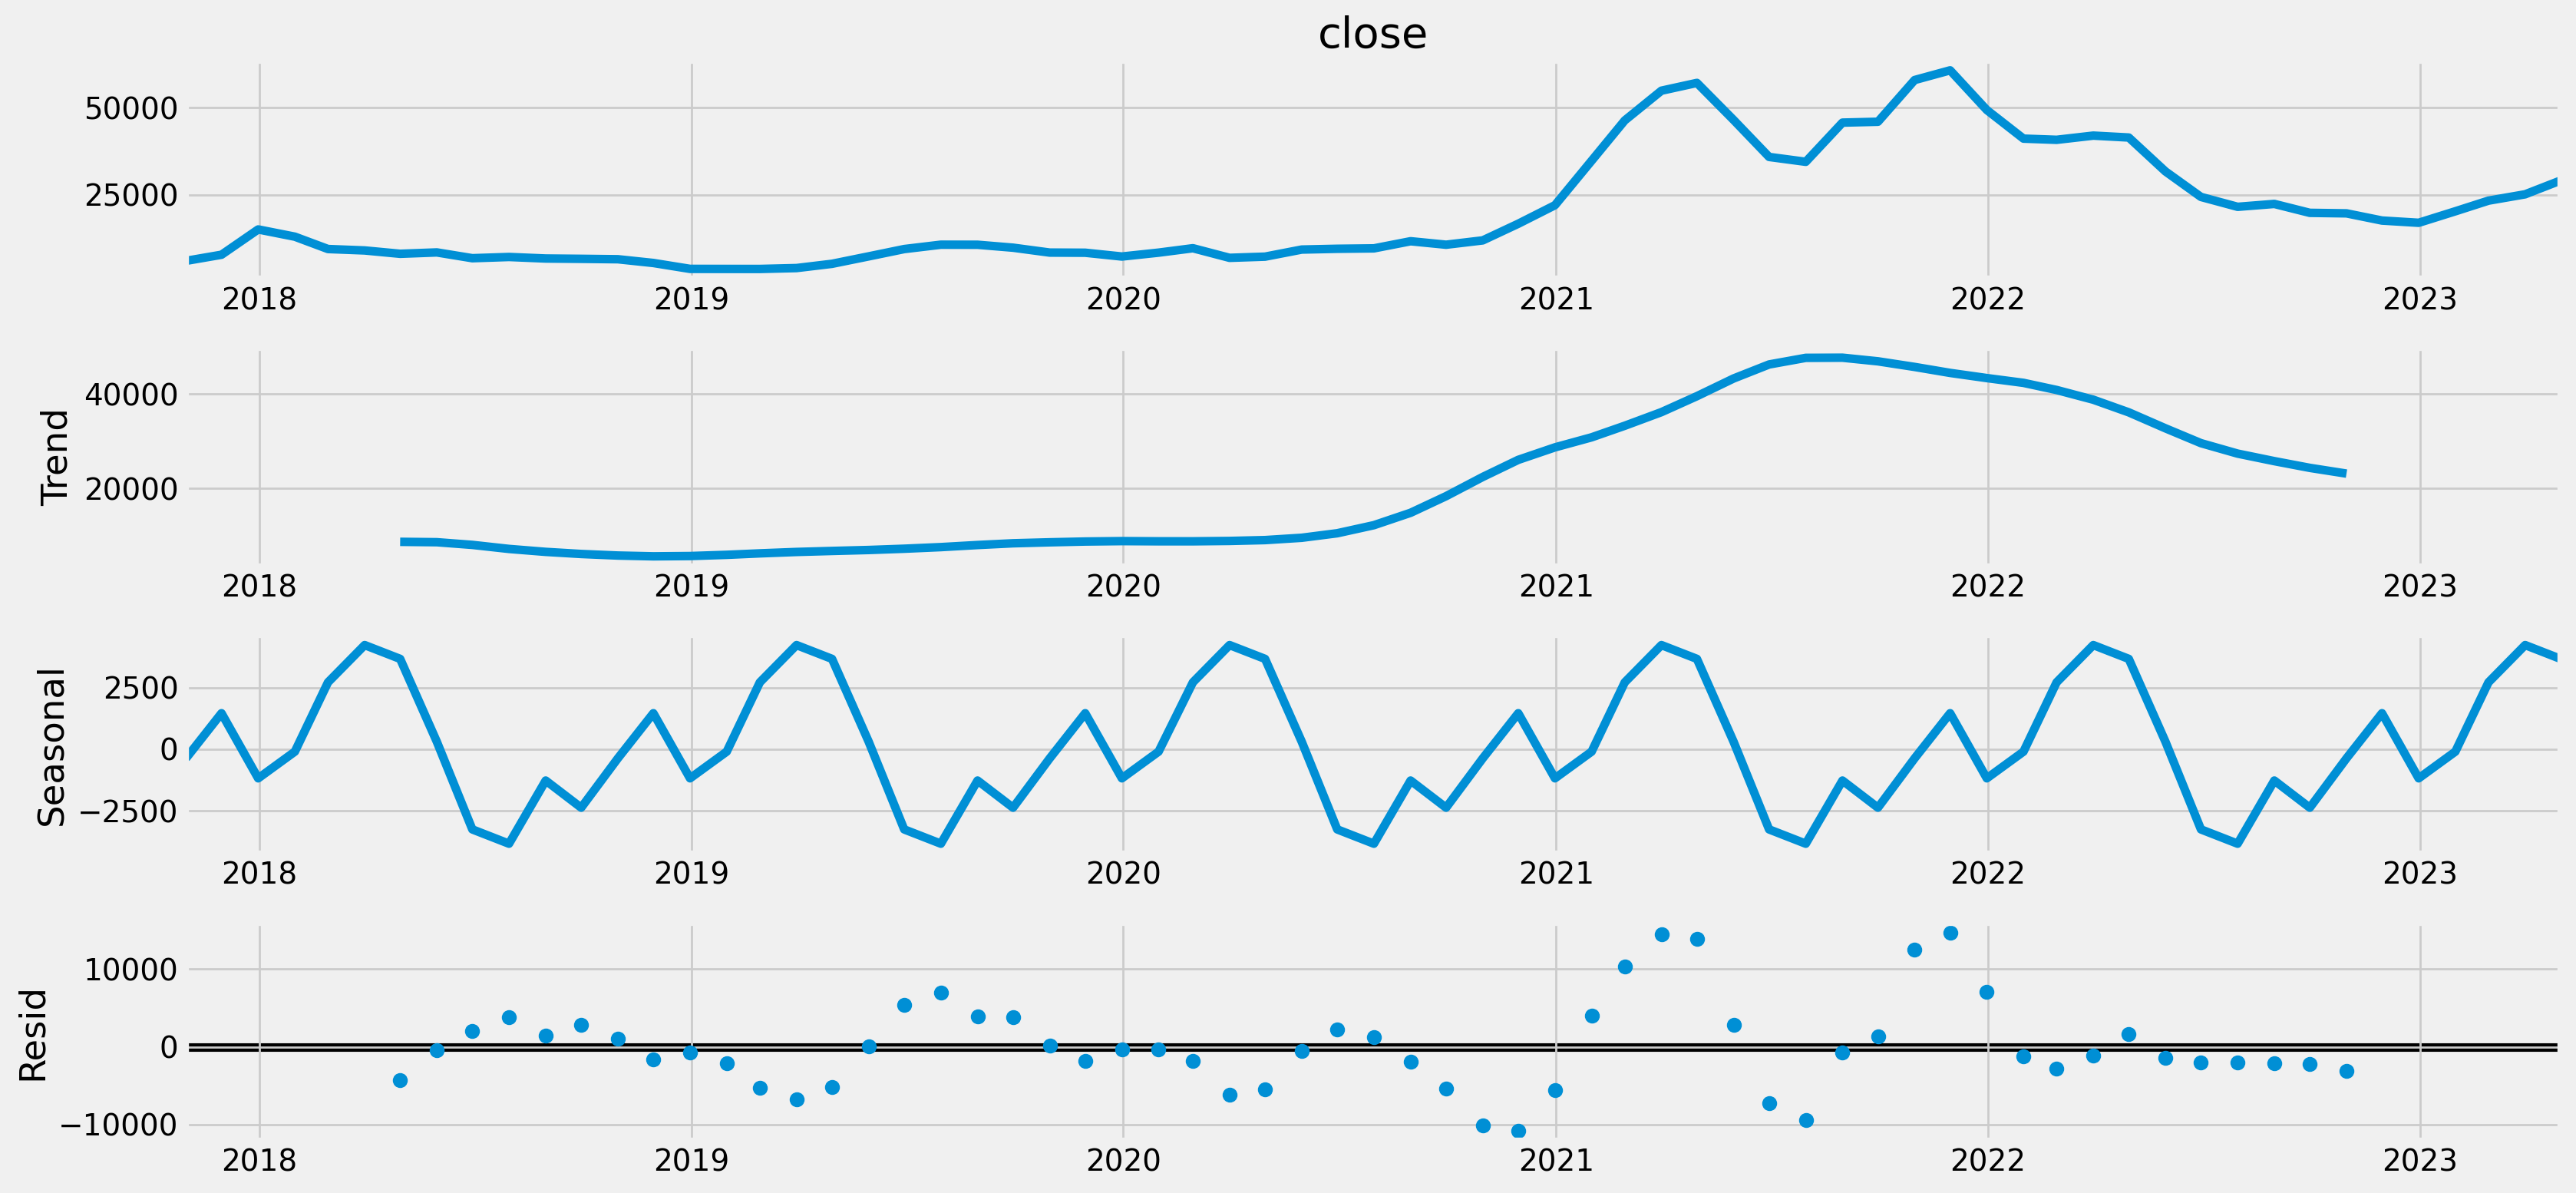

In [48]:
#will be utilizing it for graphical representation of decomposition
seasonal_decompose(df_mth.close).plot() #[3]
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f " % adfuller(df_mth.close)[1])
plt.show()

In [49]:
# implementing Box-Cox Transformations for normalization [3]
df_mth['close_box'], lmbda = stats.boxcox(df_mth.close)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p =%f" % adfuller(df_mth.close_box)[1])

Augmented Dickey Fuller(ADF) test result: p =0.681776


In [50]:
# creating new dataframe to compute monthly seasonal differentition for 12 months [3]
df_mth['box_diff_seasonal_12'] = (df_mth.close_box - df_mth.close_box.shift(12))
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff_seasonal_12[12:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.148208


In [51]:
#creating new dataframe to compute monthly seasonal differentition for 3 months [3]
df_mth['box_diff_seasonal_3'] = df_mth.close_box - df_mth.close_box.shift(3)
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff_seasonal_3[3:])[1])

Augmented Dickey Fuller(ADF) test result: p = 0.017159


Augmented Dickey Fuller(ADF) test result: p = 0.000513


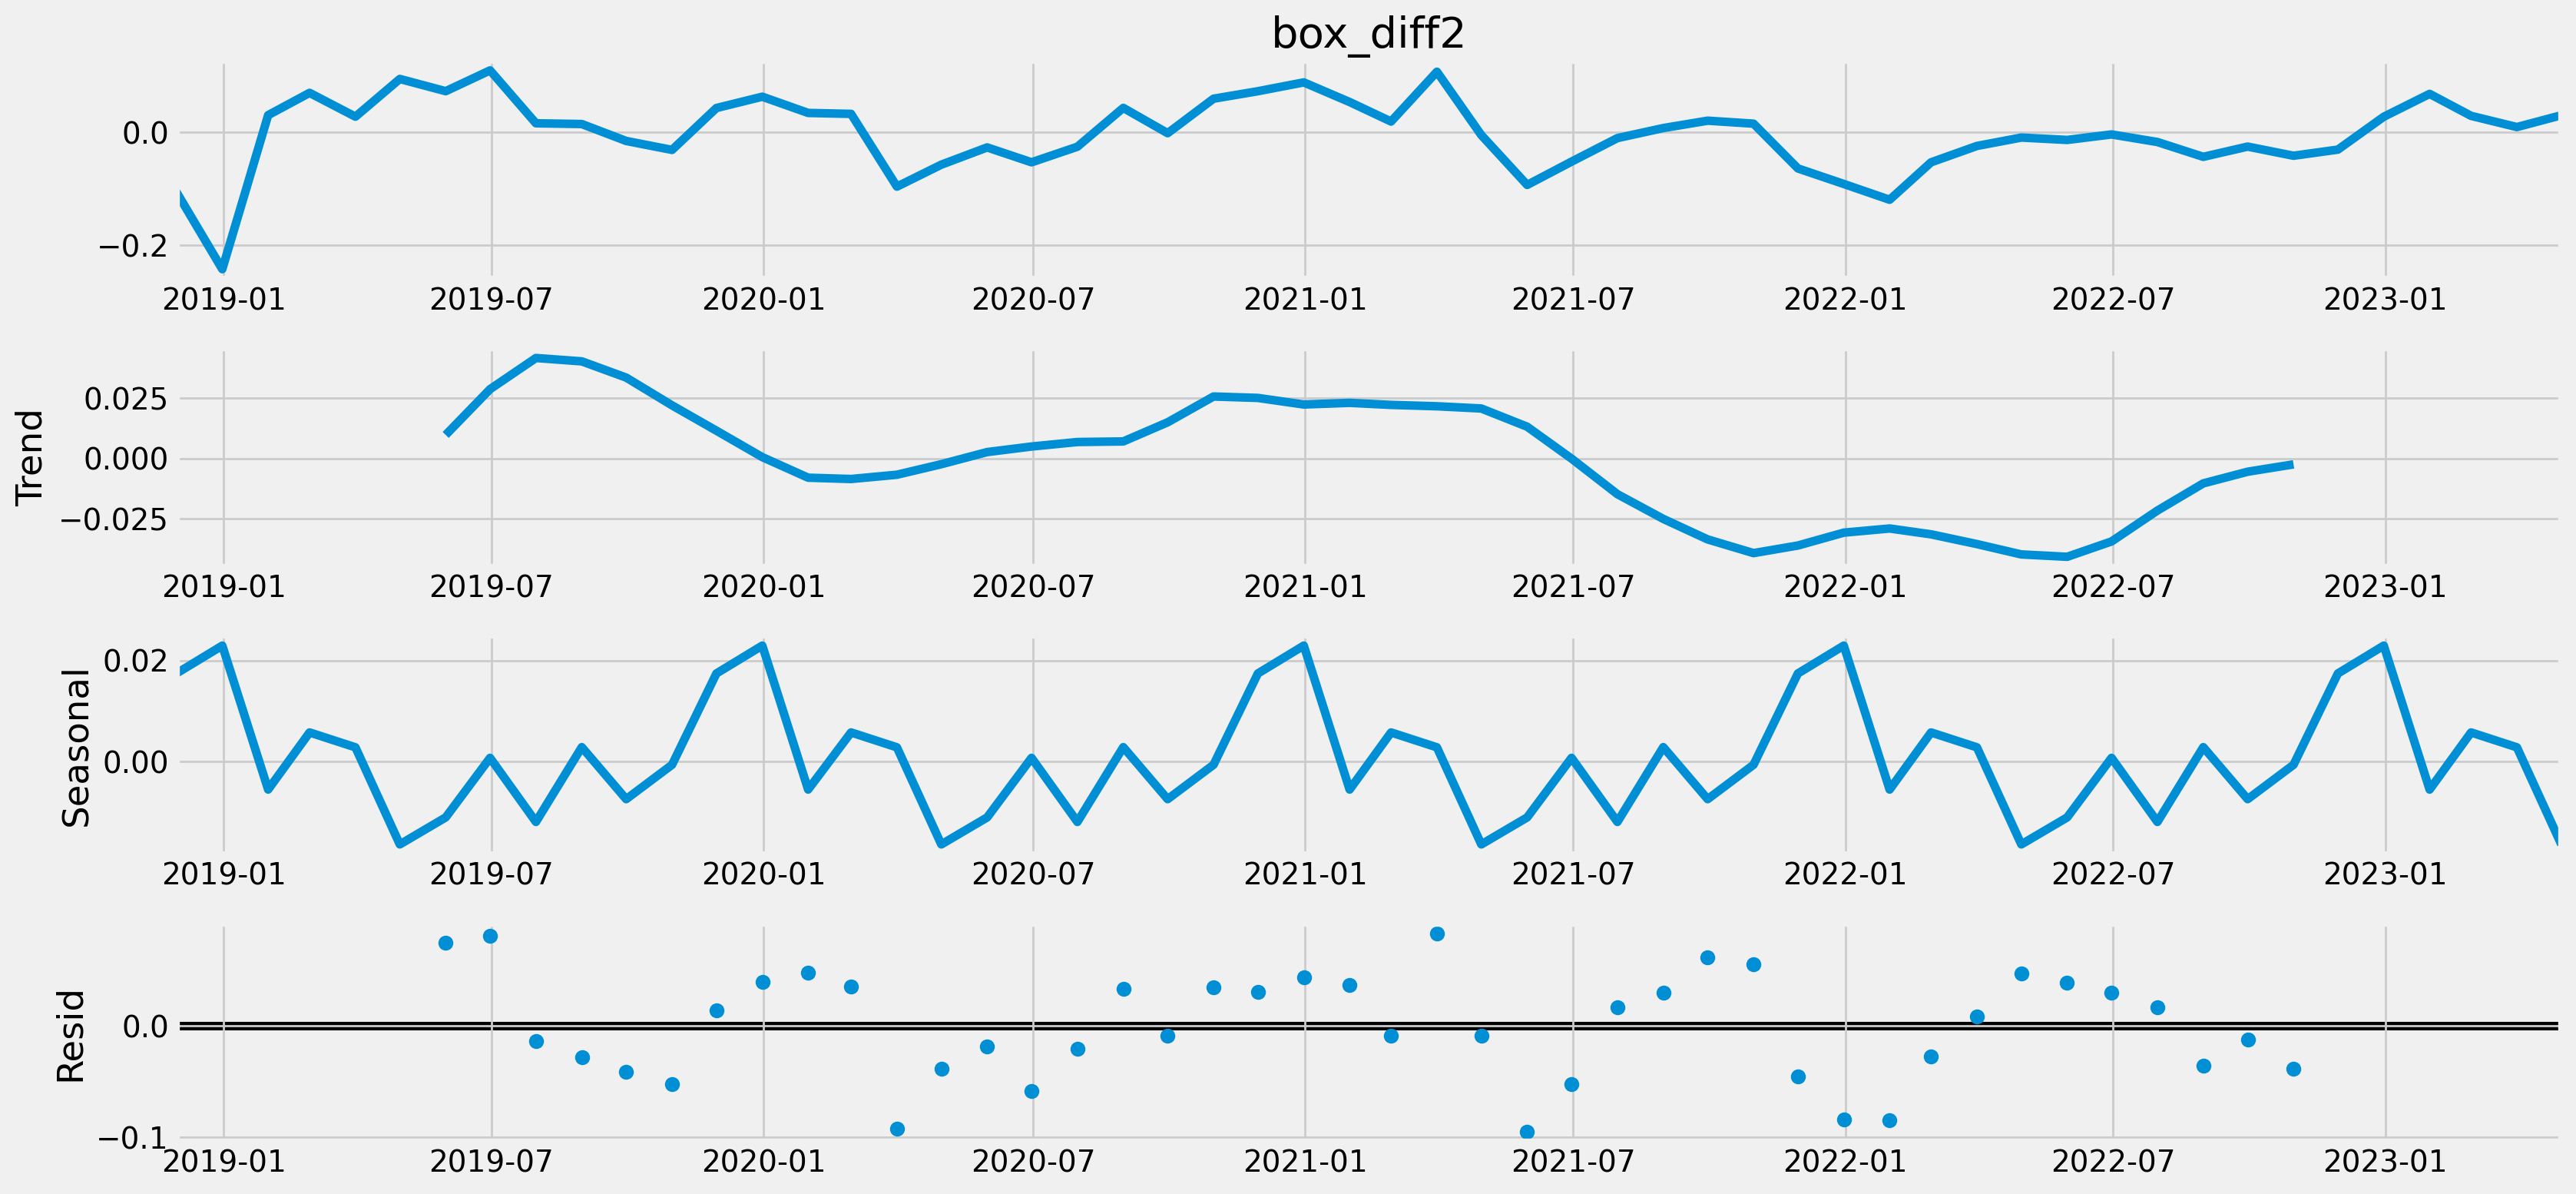

In [52]:
# #creating new dataframe to compute implement differentition for 12 months [3]
df_mth['box_diff2'] = (df_mth.box_diff_seasonal_12 - df_mth.box_diff_seasonal_12.shift(1))

# Seasonal and Trend decomposition using Loess decomposition [3]
seasonal_decompose(df_mth.box_diff2[13:]).plot()   
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result: p = %f" % adfuller(df_mth.box_diff2[13:])[1])

plt.show()

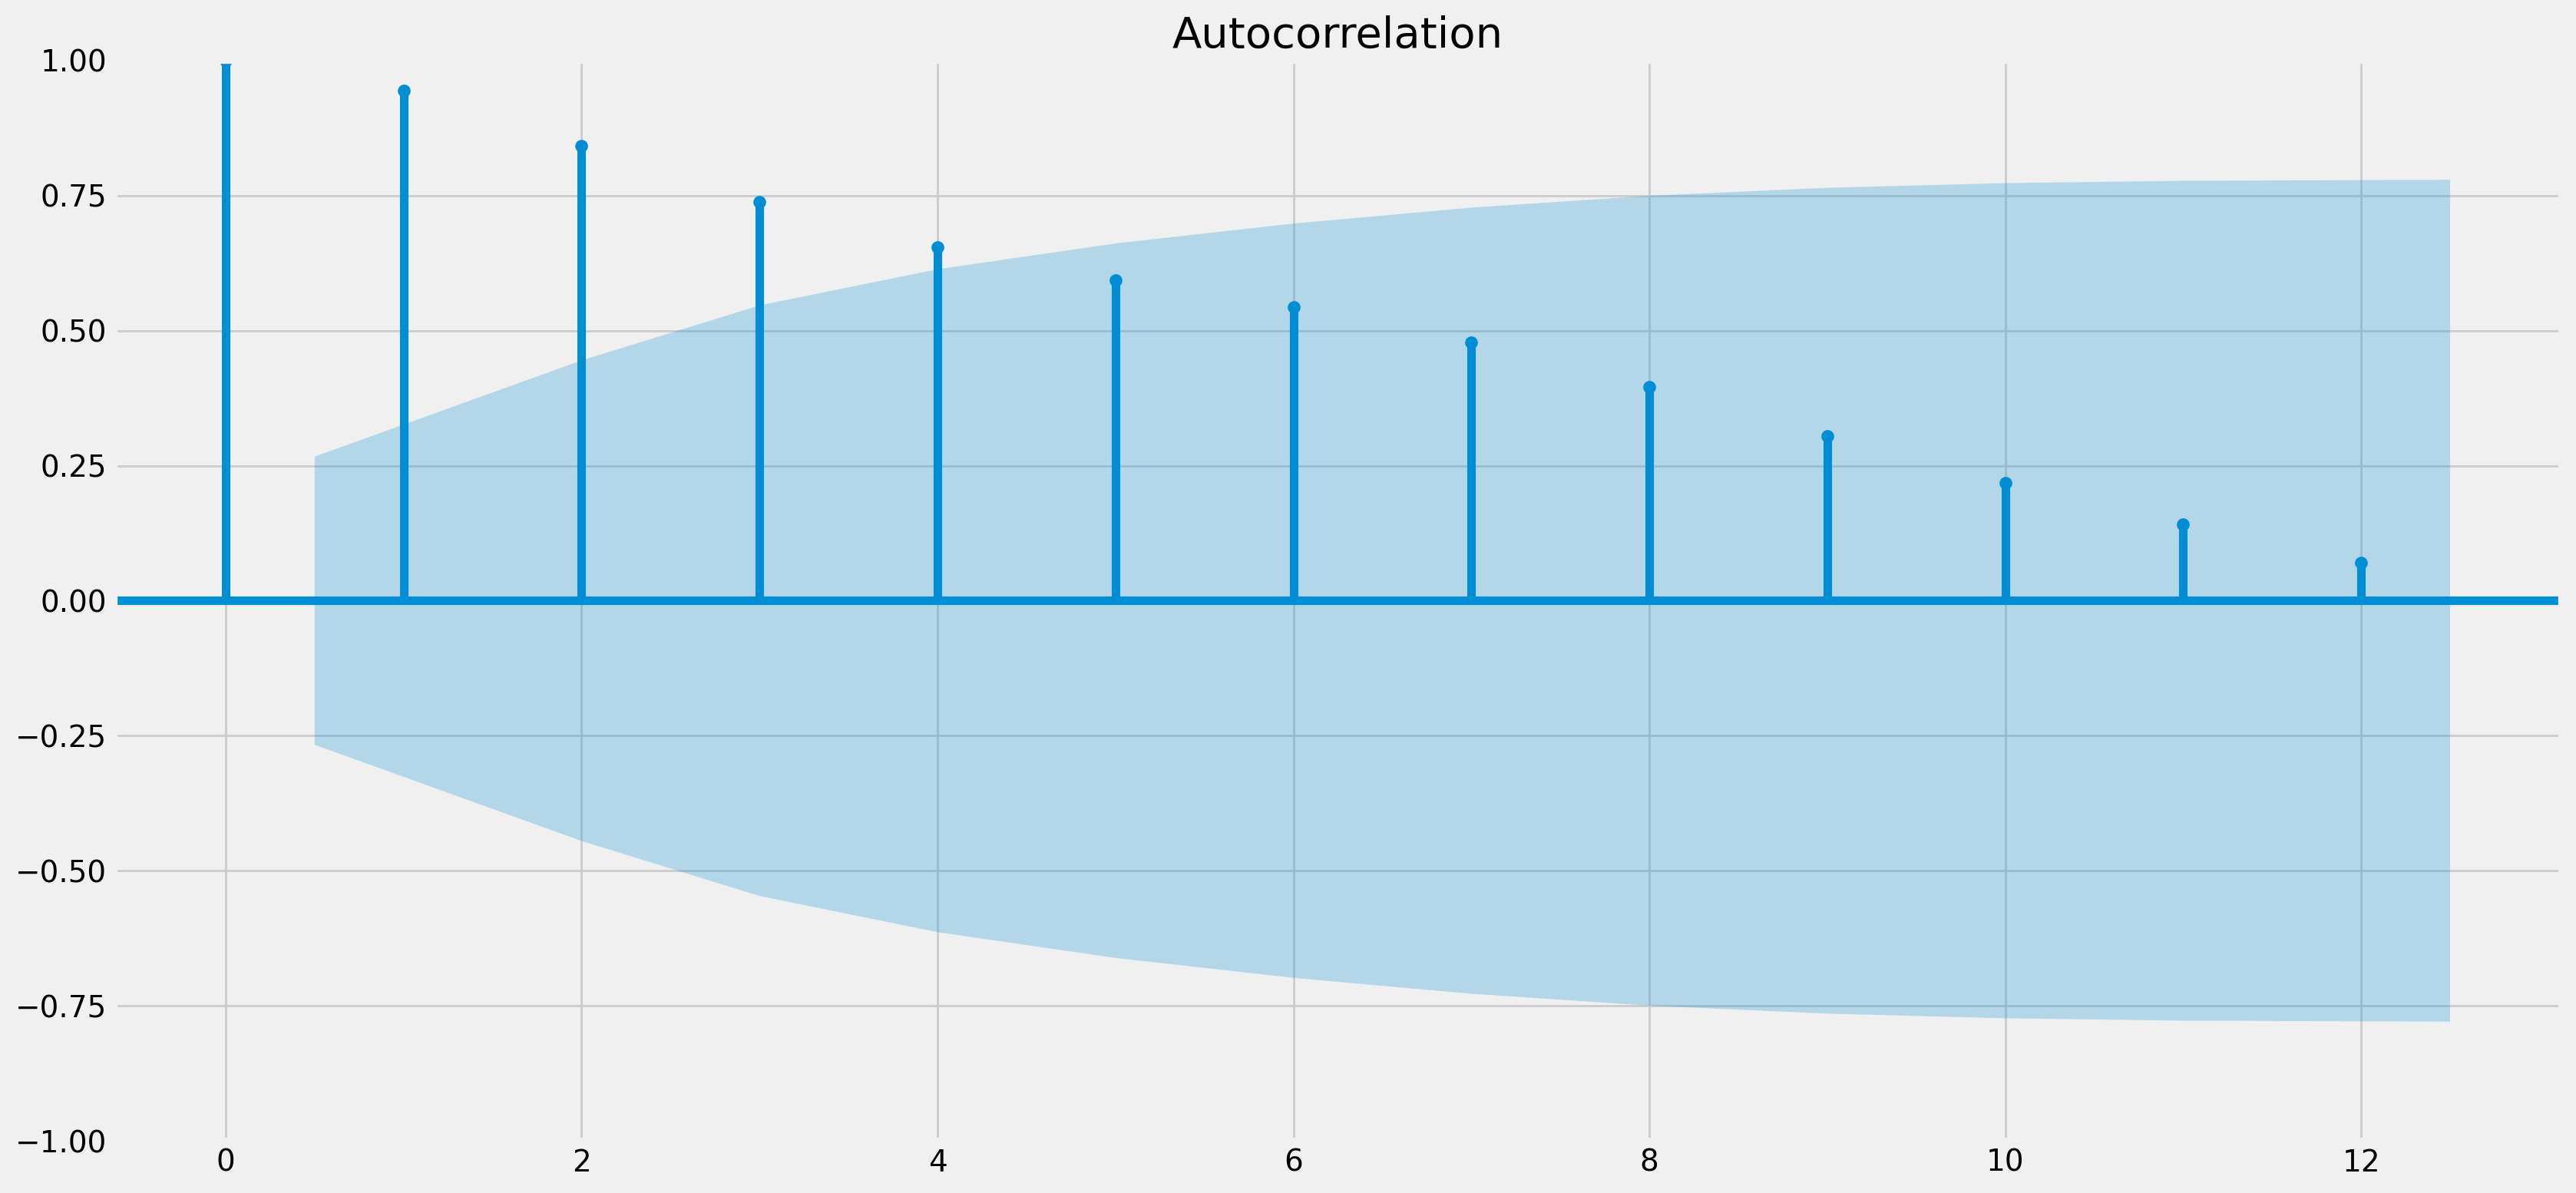

In [53]:
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_acf(df_mth.close[13:].values.squeeze(), lags=12)

plt.tight_layout()
plt.show()

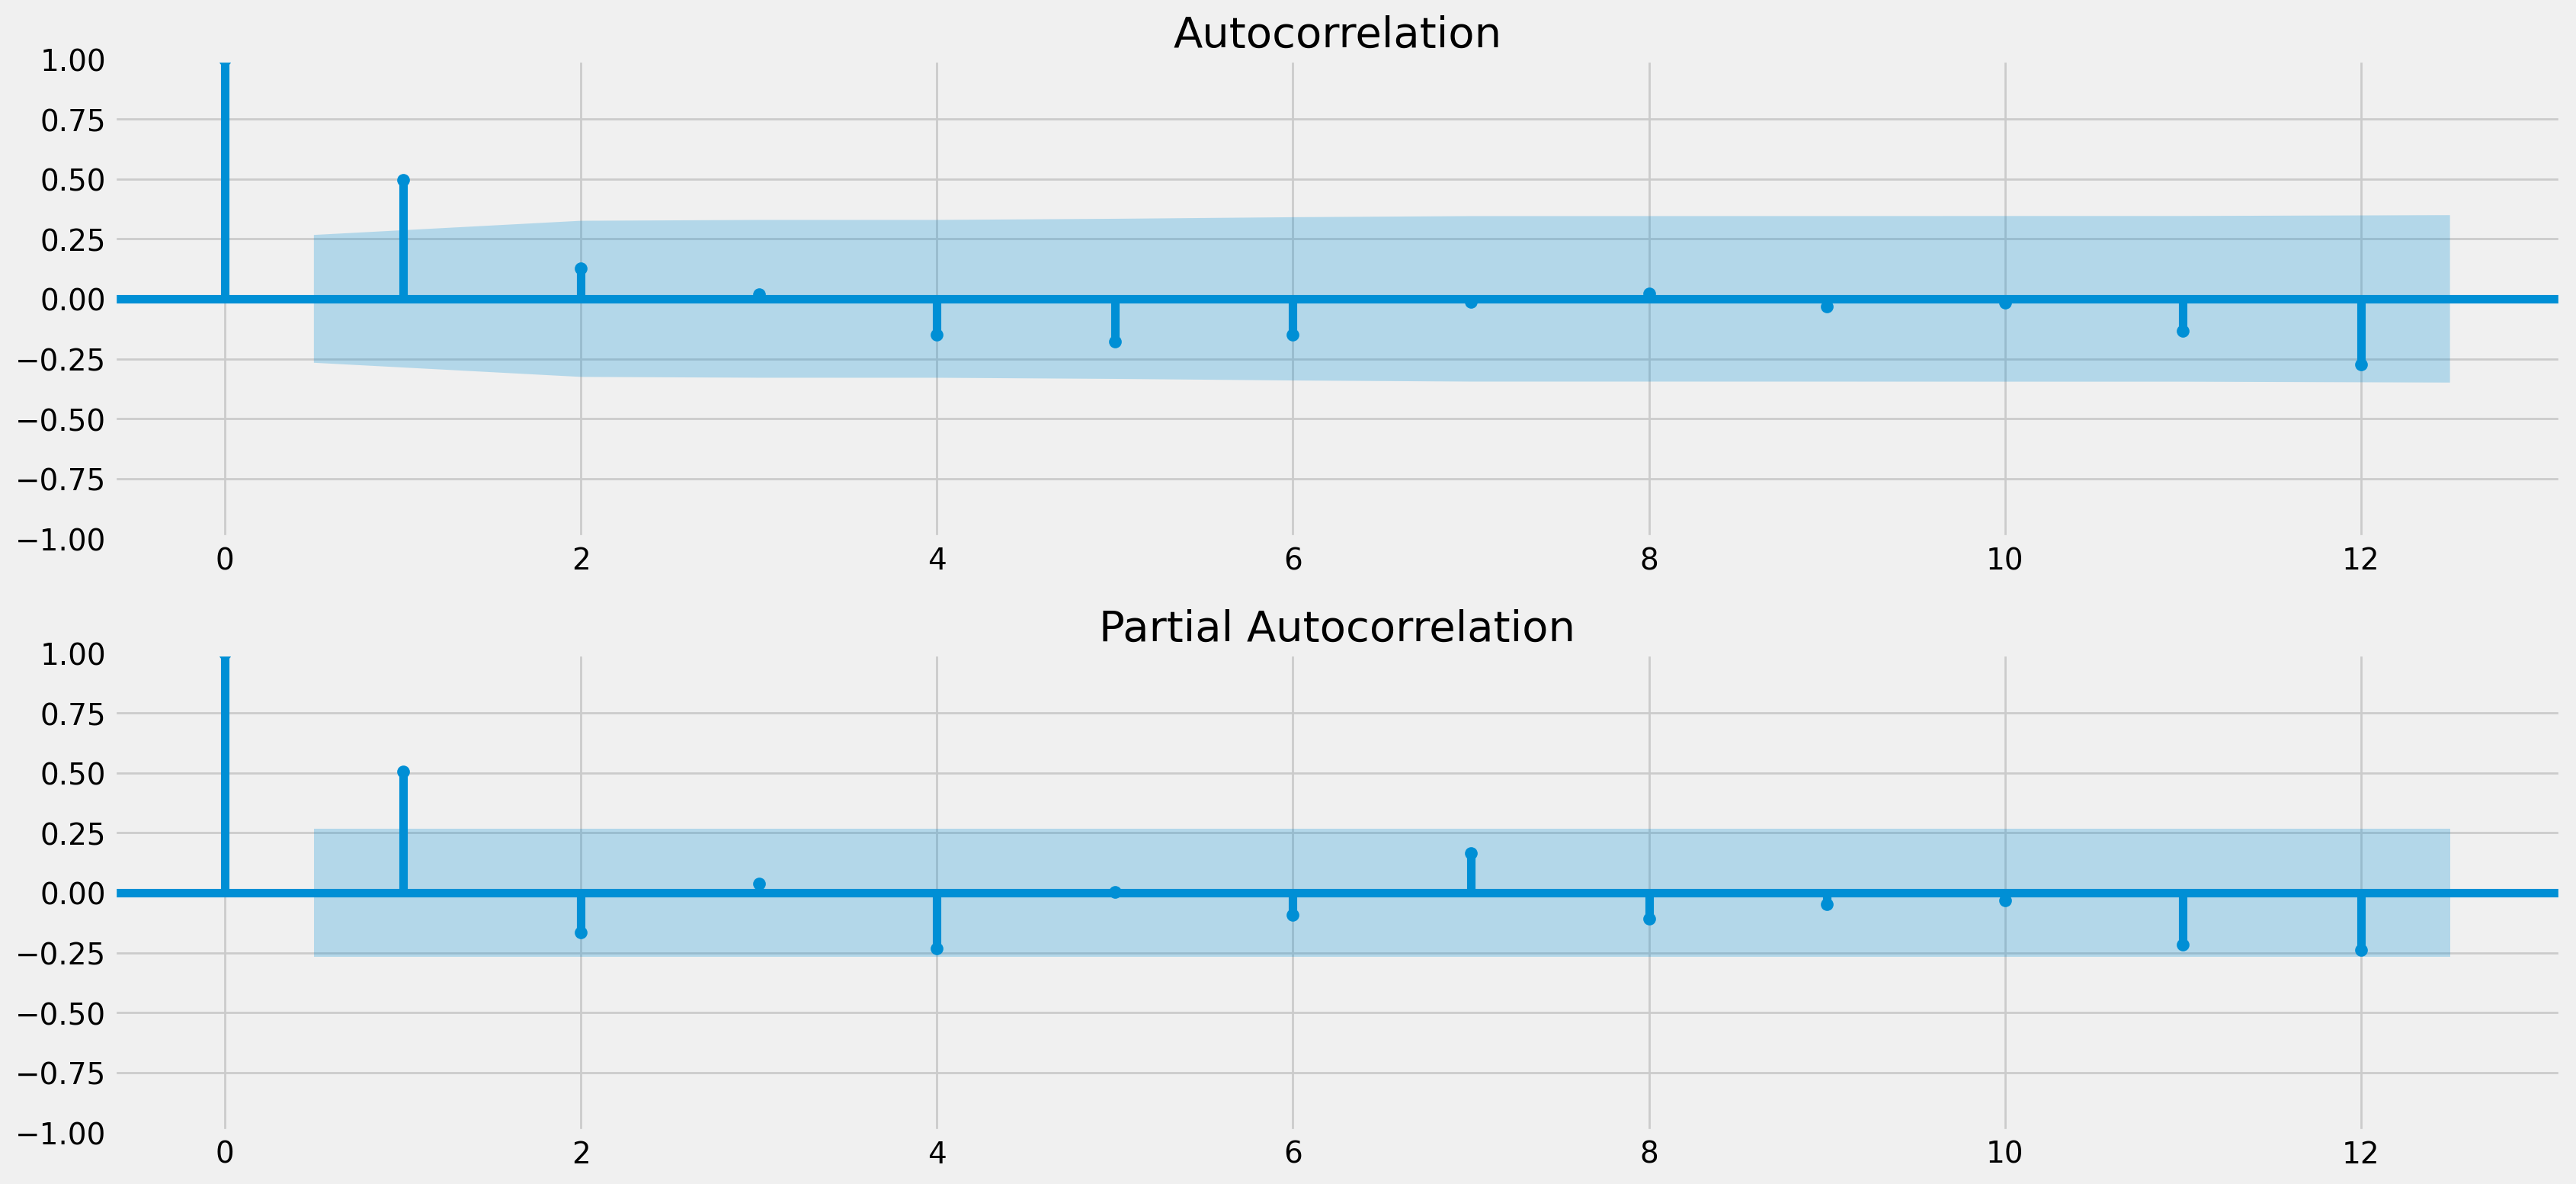

In [54]:
# Initial parameter approximation 
#PlottingAutocorrelation(ACF) and Partial Autocorrelation(PACF) Plots[3]
ax = plt.subplot(211)
# Plot the autocorrelation function [3]
plot_acf(df_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#plotting ACF graph to check for AR value autocorrelation_plot(bc_mth.close) [3]
plot_pacf(df_mth.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()
plt.show()

In [55]:
#Model building phase
#building ARIMA model
# Initial parameter approximation[1]
import statsmodels.api as sm
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# selecting appropriate model based on (p,d,1) parameters[3]
rslt = []
aic_bst = float("inf")
warnings.filterwarnings('ignore')
model = sm.tsa.arima.ARIMA(df_mth.close_box, order=(7, 1, 3))
result=model.fit()

In [56]:
#representation of summary of appropriate ARIMA models[1]
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                   67
Model:                 ARIMA(7, 1, 3)   Log Likelihood                 122.709
Date:                Mon, 17 Apr 2023   AIC                           -223.419
Time:                        03:15:22   BIC                           -199.333
Sample:                    10-31-2017   HQIC                          -213.901
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3453      1.679      0.206      0.837      -2.945       3.636
ar.L2         -0.0109      1.106     -0.010      0.992      -2.178       2.156
ar.L3          0.7954      1.112      0.715      0.4

In [57]:
#simultaneous printing and computation ADF test
print("Augmented Dickey Fuller(ADF) test result:: p=%f" % adfuller(result.resid[13:])[1])

Augmented Dickey Fuller(ADF) test result:: p=0.000000


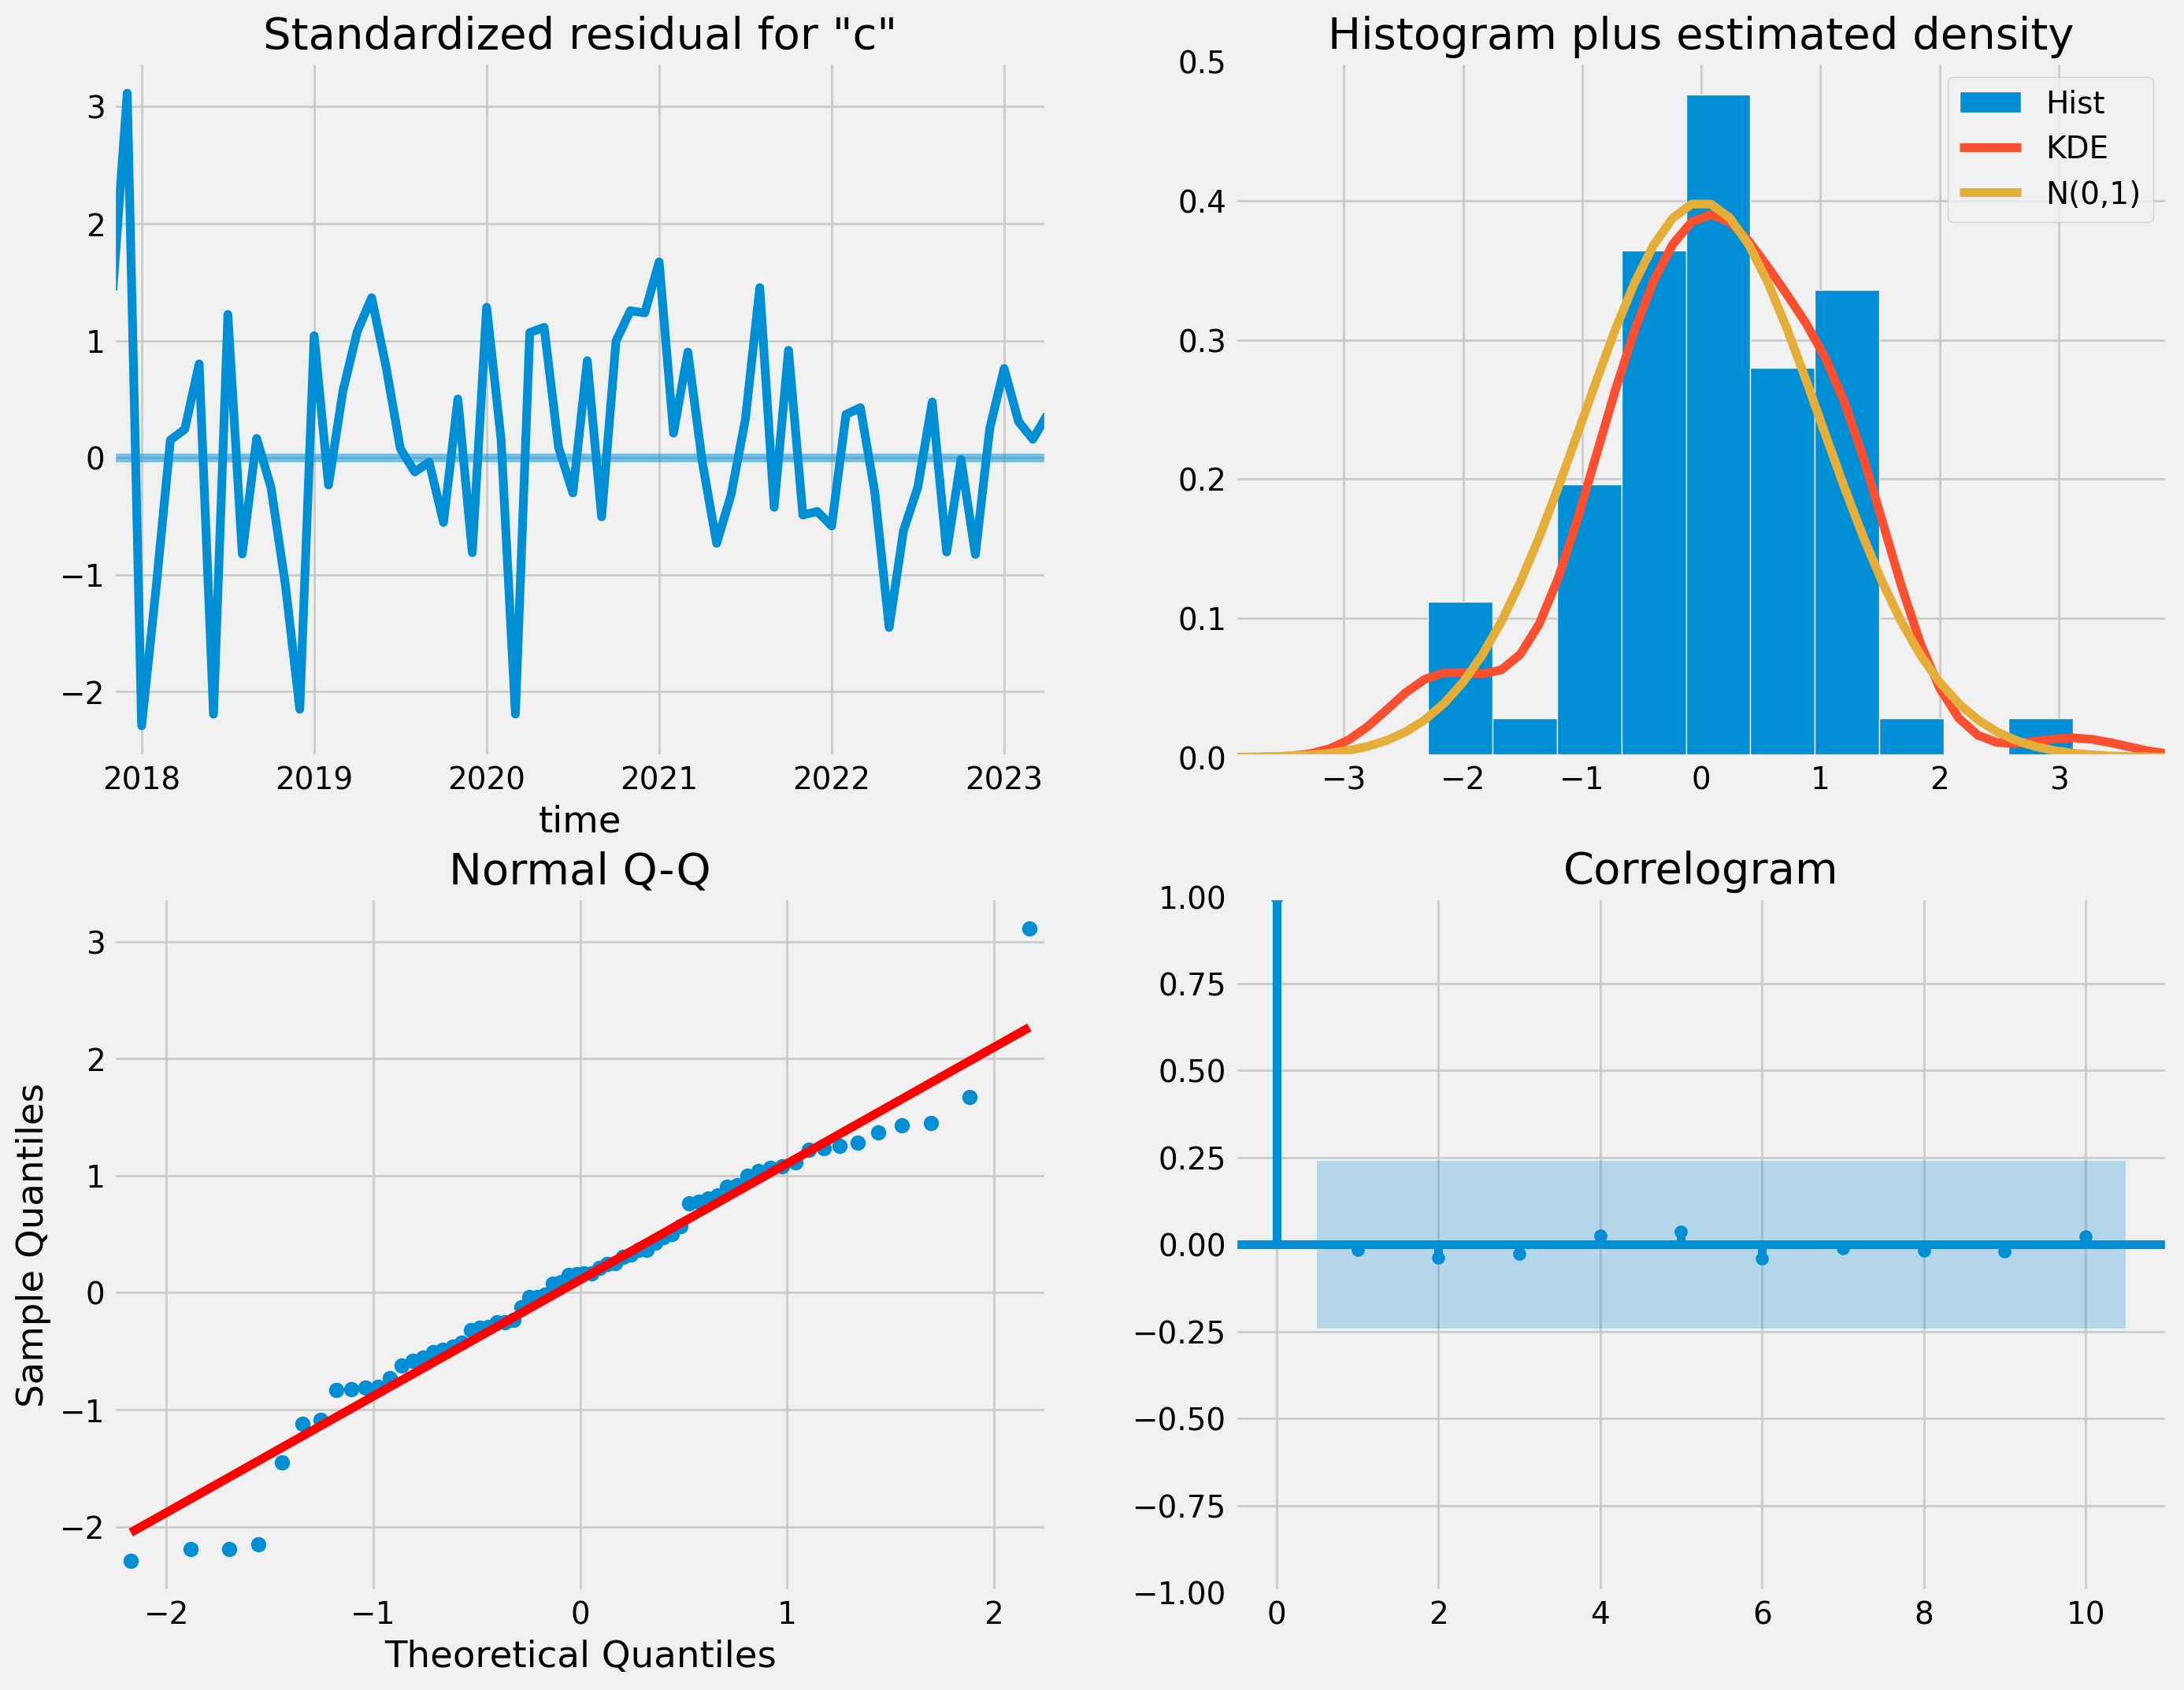

In [58]:
#running the model diagnostics functions and plotting its result [3]
result.plot_diagnostics(figsize=(15, 12))
plt.show()

In [59]:
#using inverse Box-Cox transformation function[3]
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

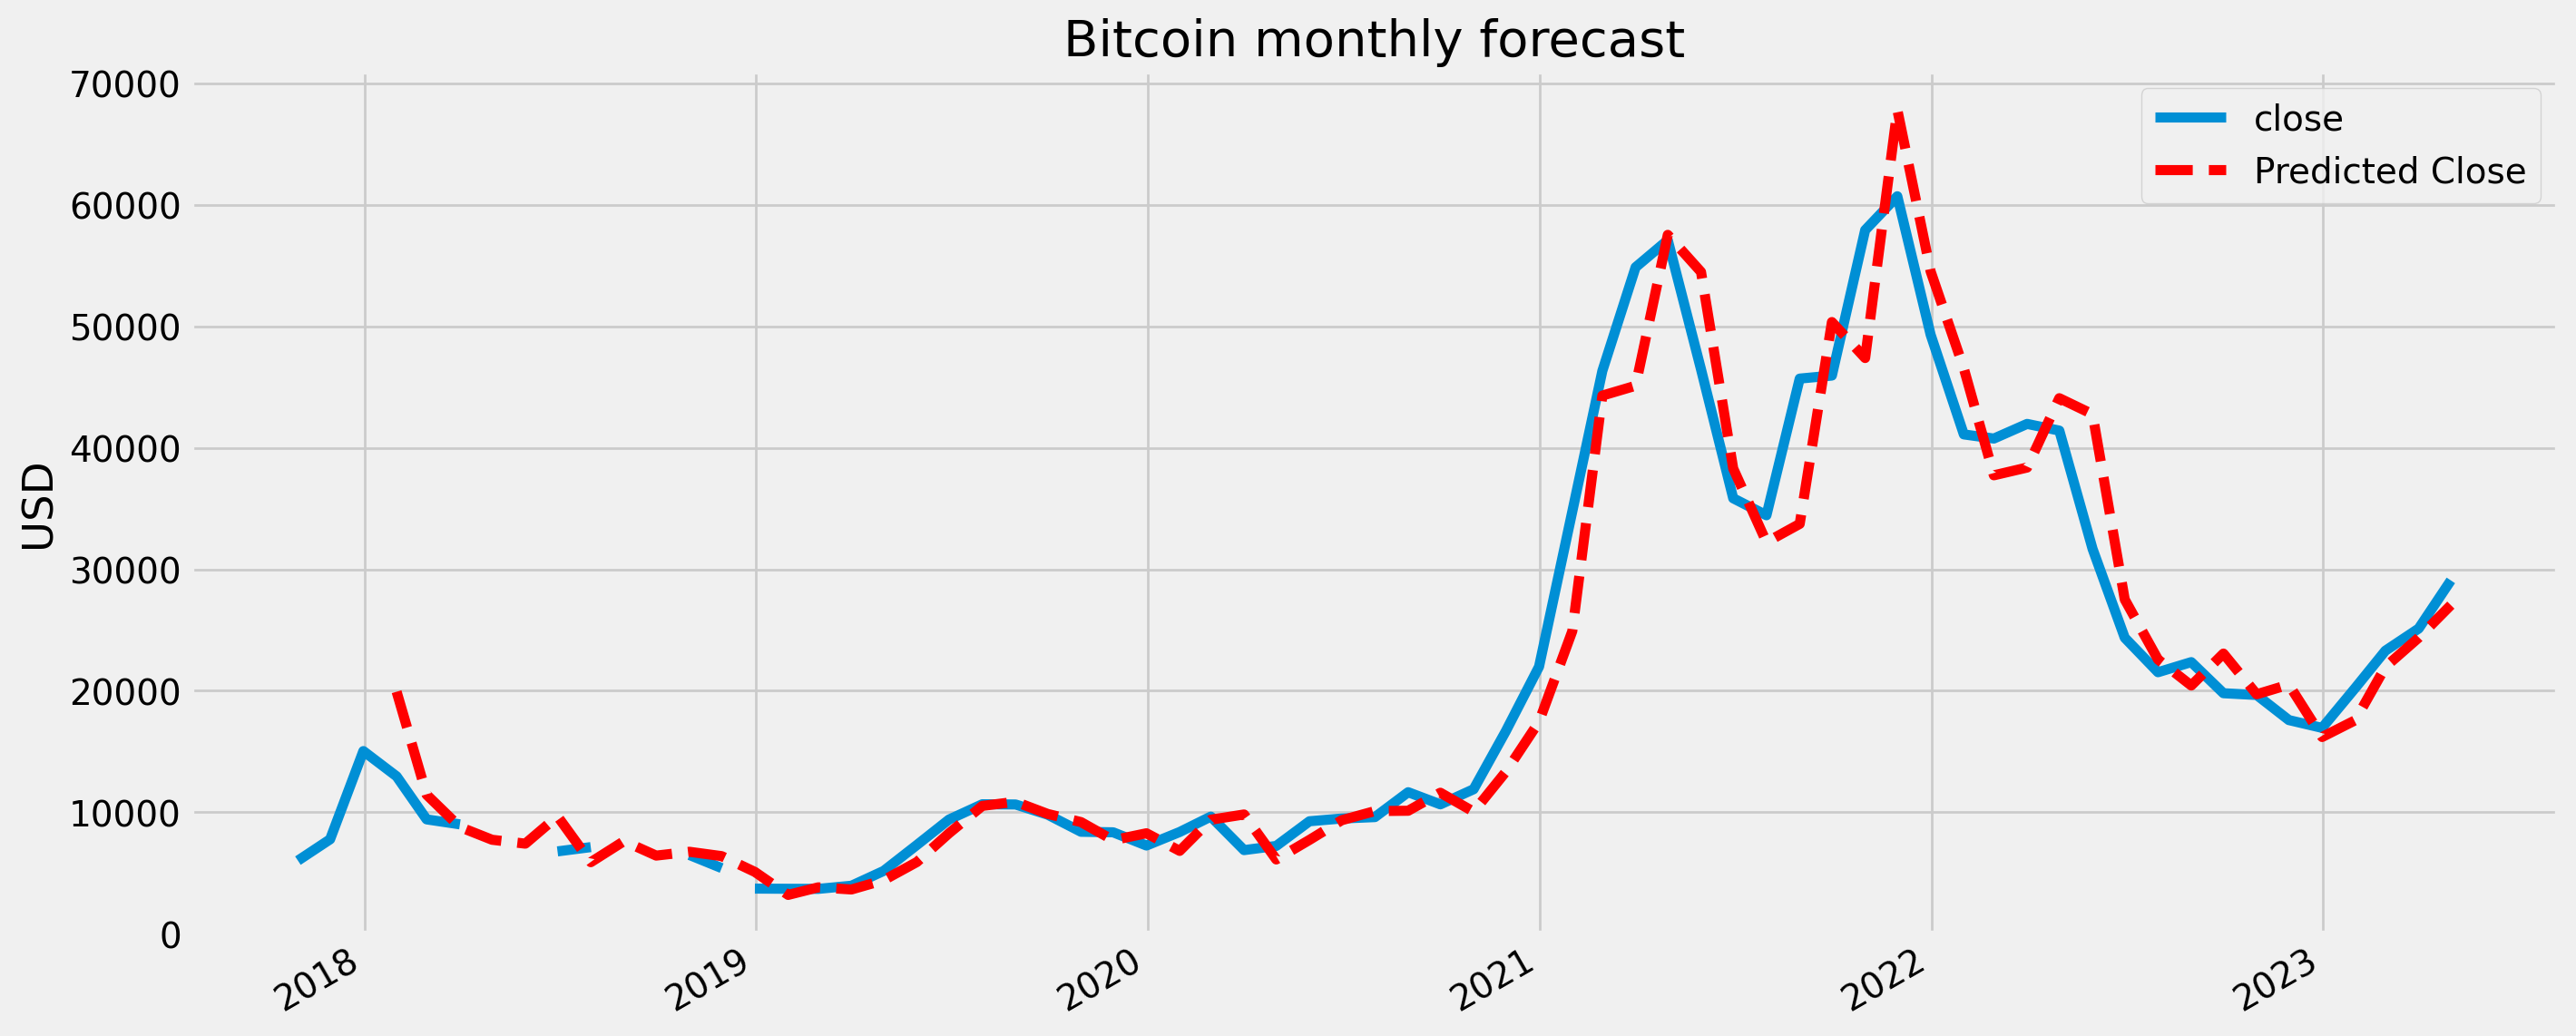

In [60]:
# predicting prices of Bitcoin's close values[3]
#storing the predictions into a new dataframe
df_mth_pred = df_mth[['close']]
#creating a list of dates to predict prices for a particular range
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), 
             datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31),
             datetime(2018, 11, 30), datetime(2018, 12, 31)]
#new dataframe with stored predictions over a period of time
future = pd.DataFrame(index=date_list, columns= df_mth.columns)
df_mth_pred = pd.concat([df_mth_pred, future])

#monthly forecasting of the values of Bitcoin's close prices
df_mth_pred['forecast'] = invboxcox(result.predict(start=datetime(2018, 1, 31), end=datetime(2023, 6, 30)), lmbda)

plt.figure(figsize=(15,7))
df_mth_pred.close.plot()
df_mth_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()